# Basic Dataset Starter

This notebook contains very basic starter code for loading the real vs fake faces dataset from file and working with it. You can borrow from this to:
- start training new models (for the transfer learning and custom architecture subteams)
- analyze and look into the dataset plus implement data augmentation

## Download the data from Kaggle

In [89]:
!rm -rf real_and_fake_face real_and_fake_face_detection processed

In [90]:
from google.colab import drive
from subprocess import Popen, PIPE
# makes files from your drive accessible
drive.mount('/content/drive', force_remount=True)

# TODO - specify path to your API key via google drive
api_key_filepath = "/content/drive/MyDrive/MDST/RvF/kaggle.json"


# Kaggle API Key setup ------------------
cmd = "mkdir /root/.kaggle"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"cp -f {api_key_filepath} /root/.kaggle/"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
stdout, stderr = process.communicate()
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
cmd = f"chmod 600 /root/.kaggle/kaggle.json"
process = Popen(cmd.split(), stdout=PIPE, stderr=PIPE)
print(stdout.decode("utf-8"), stderr.decode("utf-8"))
# ------------------------------
!kaggle datasets download -d ciplab/real-and-fake-face-detection
!unzip -q real-and-fake-face-detection.zip

Mounted at /content/drive
 mkdir: cannot create directory ‘/root/.kaggle’: File exists

 
 
real-and-fake-face-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


# Setup PyTorch Data Loading

The code in the next cell can be copied into your notebook to load the downloaded data correctly. It does two things:
- processes the dataset into a train and test set
- creates data loaders for the training and testing data

Don't worry about the details. If you're on the dataset team, you'll want to read carefully through this part

In [108]:
from imageio.v3 import imread
import pandas as pd
from pathlib import Path
from random import random
from shutil import copy
import torch
from torch.utils.data import Dataset, DataLoader

class RealAndFakeFaceProcessor:
    def __init__(self, directory, train_test_split = 0.7) -> None:
        self.train_test_split = train_test_split

        self.train_index = 0
        self.test_index = 0

        self.src_directory = Path(directory)
        self.directory = self.src_directory.parent / "processed"

        self.tgt_train = self.directory / "train"
        self.tgt_train.mkdir(parents=True, exist_ok=True)

        self.tgt_test = self.directory / "test"
        self.tgt_test.mkdir(parents=True, exist_ok=True)

        self.index_by_type = {"index":[], "partition": [], "type": [], "label": []}
        self.__process("training_fake","easy")
        self.__process("training_fake","mid")
        self.__process("training_fake","hard")
        self.__process("training_real","real")

        df = pd.DataFrame(self.index_by_type)
        df.to_csv(self.directory / "images.csv", index=False)


    def __add_image_to_record(self, index: int, partition: str, type: str, label: int):
        """Real - label is 1, Fake - label is 0"""
        self.index_by_type["index"].append(index)
        self.index_by_type["partition"].append(partition)
        self.index_by_type["type"].append(type)
        self.index_by_type["label"].append(label)


    def __process(self, subdir: str, type: str) -> None:
        src = self.src_directory / subdir
        label = 1 if type == "real" else 0

        for image in src.iterdir():
            if image.name.startswith(type):
                random_number = random()
                if random() > self.train_test_split:
                    copy(image.absolute(), self.tgt_test / f"{self.test_index}.png")
                    self.__add_image_to_record(self.test_index, "test", type, label)
                    self.test_index += 1
                else:
                    copy(image.absolute(), self.tgt_train / f"{self.train_index}.png")
                    self.__add_image_to_record(self.train_index, "train", type, label)
                    self.train_index += 1

class RealAndFakeFaceDataset(Dataset):
    def __init__(
        self,
        directory: str,
        partition: str ="train"
    ) -> 'RealAndFakeFaceDataset':
        self.partition = partition
        if partition not in ("train", "test"):
            raise ValueError(f"Invalid partition specified - {partition}")
        self.directory = Path(directory)
        self.img_directory = self.directory / partition
        metadata = pd.read_csv(self.directory / "images.csv")
        self.metadata = metadata[metadata["partition"] == self.partition]

    def __len__(self) -> int:
        return len(self.metadata)

    def __getitem__(self, index: int) -> tuple[torch.tensor, int]:
        filename = self.img_directory / f"{index}.png"
        label = self.metadata.iloc[index]["label"]
        return torch.from_numpy(imread(filename)), label

    def get_type(self, index) -> str:
        return self.metadata.iloc[index]["type"]

processor = RealAndFakeFaceProcessor("real_and_fake_face") # Call this to process the dataset into a train and test set
train = RealAndFakeFaceDataset("processed", "train")
test = RealAndFakeFaceDataset("processed", "test")

train_loader = DataLoader(train, batch_size = 32, num_workers=2)
test_loader = DataLoader(test, batch_size = 32, num_workers=2)

# Example Usage - Looking at Images

Image 1 in the training set has type easy and is fake


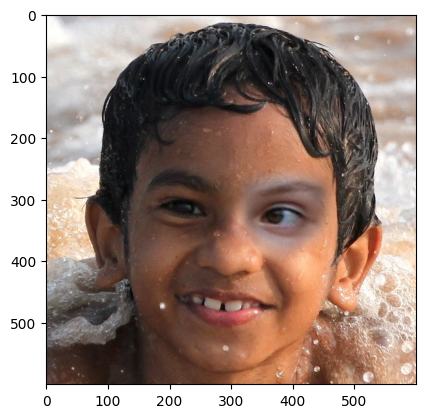

In [102]:
from matplotlib import pyplot as plt

# getting the first image in the training set
index = 1
image, label = train[index]
print(f"Image {index} in the training set has type {train.get_type(index)} and is {'fake' if label == 0 else 'real'}")
plt.imshow(image)

Image 10 in the testing set has type easy and is fake


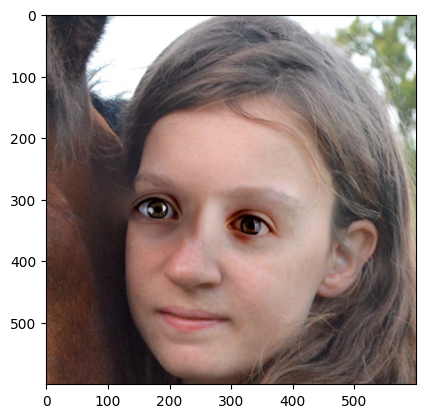

In [103]:
# getting the first image in the testing set
index = 10
image, label = test[index]
print(f"Image {index} in the testing set has type {test.get_type(index)} and is {'fake' if label == 0 else 'real'}")
plt.imshow(image)

# Example Usage - Iterating through batches to train model

In [109]:
from tqdm import tqdm

for (X, y) in tqdm(train_loader):
    # include pytorch training code here
    pass

100%|██████████| 45/45 [00:17<00:00,  2.52it/s]
